# COVID-19 Global Prediction using fbprophet

In [158]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics as sklm
#import plotly.express as px
import plotly.graph_objects as go
import folium 
from folium import plugins
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric


# Manipulating the default plot size
plt.rcParams['figure.figsize'] = 10, 12

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

In [159]:
# Importing the Datasets
confirmed_jhu = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
recovered_jhu = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
deaths_jhu = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
countrycase_jhu = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv')

# Renaming the columns
confirmed_jhu.rename(columns={'Country/Region':'Country'}, inplace=True)
recovered_jhu.rename(columns={'Country/Region':'Country'}, inplace=True)
deaths_jhu.rename(columns={'Country/Region':'Country'}, inplace=True)
countrycase_jhu.rename(columns={'Country_Region':'Country'}, inplace=True)

In [160]:
# Datewise Confirmed case
df_c=confirmed_jhu.iloc [:,4:] 
df_c=df_c.T
df_c['sum'] = df_c[df_c.columns].sum(axis=1)
date=pd.to_datetime(df_c.index)
df1 = pd.DataFrame(date, columns=['Date'])
df1['Confirmed']=pd.Series(df_c['sum'].values)
df1
#confirmed_fbp=df1
confirmed_fbp = df1.copy(deep=True)

In [161]:
# Datewise Recovered case
df_r=recovered_jhu.iloc [:,4:] 
df_r=df_r.T
df_r['sum'] = df_r[df_r.columns].sum(axis=1)
date=pd.to_datetime(df_r.index)
df2= pd.DataFrame(date, columns=['Date'])
df2['Recovered']=pd.Series(df_r['sum'].values)
df2
recovered_fbp=df2.copy(deep=True)

In [162]:
# Datewise Death case
df_d=deaths_jhu.iloc [:,4:] 
df_d=df_d.T
df_d['sum'] = df_d[df_d.columns].sum(axis=1)
date=pd.to_datetime(df_d.index)
df3= pd.DataFrame(date, columns=['Date'])
df3['Deaths']=pd.Series(df_d['sum'].values)
df3
death_fbp=df3.copy(deep=True)

In [163]:
# Replacing NULL columns with '0's
for index, row in confirmed_fbp.iterrows():
    if row['Confirmed'] is None:
        row['Confirmed'] = 0.0

for index, row in death_fbp.iterrows():
    if row['Deaths'] is None:
        row['Deaths'] = 0.0
        
for index, row in recovered_fbp.iterrows():
    if row['Recovered'] is None:
        row['Recovered'] = 0.0

In [164]:
#Plotting datewise confirmed/ deaths/ recovered cases
fig = go.Figure()
fig.add_trace(go.Scatter(x=confirmed_fbp['Date'], y=confirmed_fbp['Confirmed'], name='Confirmed',line=dict(color='blue')))
fig.add_trace(go.Scatter(x=death_fbp['Date'], y=death_fbp['Deaths'], name='Deaths', line=dict(color='Red')))
fig.add_trace(go.Scatter(x=recovered_fbp['Date'], y=recovered_fbp['Recovered'], name='Recovered', line=dict(color='Green')))
fig.update_layout(title='Covid-19 World Graph', xaxis_tickfont_size=12,xaxis=dict(title='Dates'), yaxis=dict(title='Total No. of Cases'))

fig.show()

## Design, Analysis and Forecast in fbprophet

#### Confirmed Case: Data preprocessing

In [165]:
# preprocessing dataframe for fbprophet
confirmed_fbp.columns = ['ds','y']
confirmed_fbp['ds'] = pd.to_datetime(confirmed_fbp['ds'])

#### Confirmed Case: model, fit and predict

In [171]:
# fitting / predicting the model
confirmed_fbp_model = Prophet(growth ='linear', 
                              seasonality_mode='multiplicative',
                              changepoint_prior_scale=0.5,
                              weekly_seasonality=True,
                              daily_seasonality=True)
confirmed_fbp_model.fit(confirmed_fbp)
confirmed_fbp_model_future = confirmed_fbp_model.make_future_dataframe(periods=30,freq='D')
confirmed_fbp_model_future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds
139,2020-06-09
140,2020-06-10
141,2020-06-11
142,2020-06-12
143,2020-06-13


In [172]:
#predicting the future with date, and upper and lower limit of y value
confirmed_fbp_model_pred = confirmed_fbp_model.predict(confirmed_fbp_model_future)
confirmed_fbp_model_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
139,2020-06-09,6.539580e+06,6.250449e+06,6.826013e+06
140,2020-06-10,6.621607e+06,6.318499e+06,6.920582e+06
141,2020-06-11,6.718488e+06,6.395974e+06,7.037611e+06
142,2020-06-12,6.804251e+06,6.466106e+06,7.148788e+06
143,2020-06-13,6.890731e+06,6.526272e+06,7.252695e+06


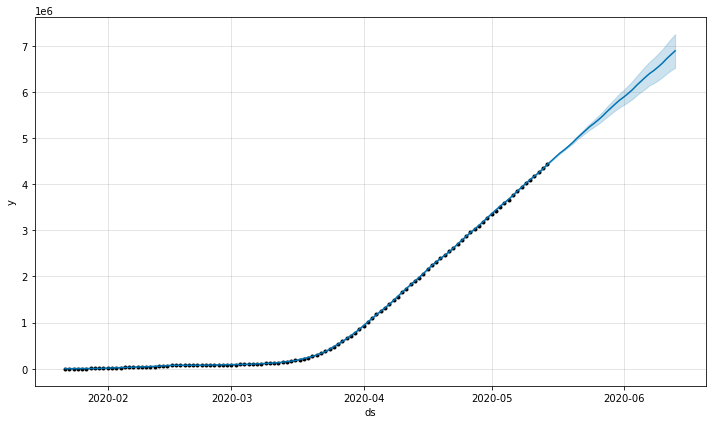

In [173]:
# plotting the predicted values in fbprophet model
confirmed_fbp_pred_plot = confirmed_fbp_model.plot(confirmed_fbp_model_pred)

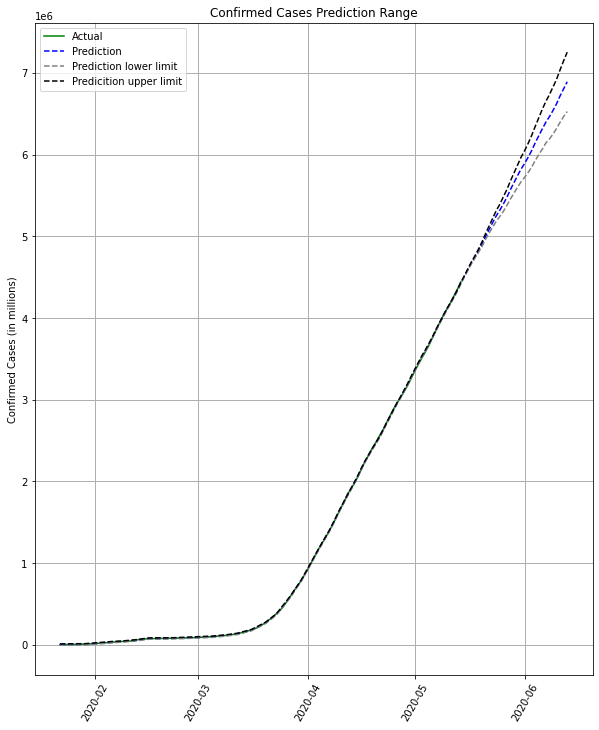

In [174]:
# matplotlib plot method
c_forecast_yhat = []
c_forecast_yhat_u = []
c_forecast_yhat_l = []

for index, row in confirmed_fbp_model_pred.iterrows():

    c_forecast_yhat.append(row['yhat'])
    c_forecast_yhat_l.append(row['yhat_lower'])
    c_forecast_yhat_u.append(row['yhat_upper'])

plt.ylabel('Confirmed Cases (in millions)')
plt.xticks(fontsize=10, rotation=60)
plt.grid(linestyle='-', linewidth=1)
plt.plot(confirmed_fbp['ds'], confirmed_fbp['y'], label='Actual', color='green')
plt.plot(confirmed_fbp_model_pred['ds'], c_forecast_yhat, label='Prediction', linestyle='dashed', color='blue')
plt.plot(confirmed_fbp_model_pred['ds'], c_forecast_yhat_l, label='Prediction lower limit', linestyle='dashed', color='grey')
plt.plot(confirmed_fbp_model_pred['ds'], c_forecast_yhat_u, label='Predicition upper limit', linestyle='dashed', color='black')
plt.title("Confirmed Cases Prediction Range")
plt.legend()
plt.show()

#### Confirmed Case: Trends

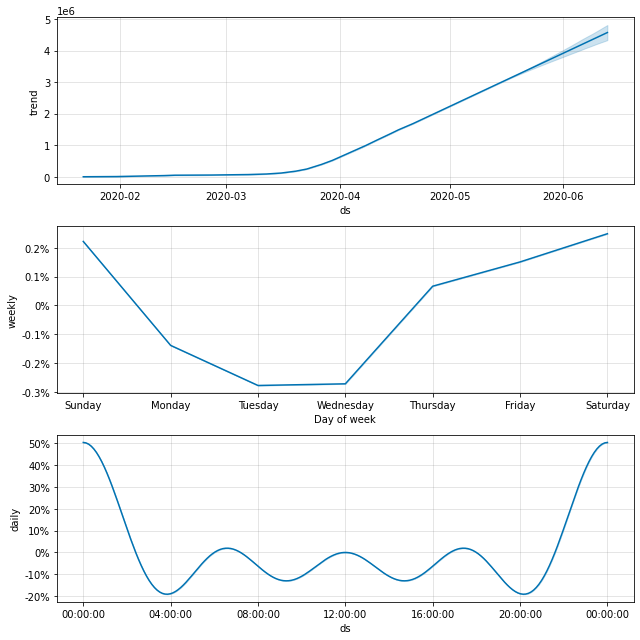

In [175]:
# Trends: daily/ weekly
confirmed_forecast_plot =confirmed_fbp_model.plot_components(confirmed_fbp_model_pred)

#### Confirmed Case: Cross Validation, Performance Metrics

In [131]:
# Cross validating the prediction
conf_cv = cross_validation(confirmed_fbp_model, initial= '15 days', horizon = '5 days')
conf_cv.tail()

INFO:fbprophet:Making 37 forecasts with cutoffs between 2020-02-07 00:00:00 and 2020-05-07 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
180,2020-05-08,3.915912e+06,3.910061e+06,3.921083e+06,3938064,2020-05-07
181,2020-05-09,3.996850e+06,3.989771e+06,4.003246e+06,4024009,2020-05-07
182,2020-05-10,4.077118e+06,4.068882e+06,4.085305e+06,4101699,2020-05-07
183,2020-05-11,4.143761e+06,4.132261e+06,4.155169e+06,4177502,2020-05-07
184,2020-05-12,4.217188e+06,4.199844e+06,4.233701e+06,4261747,2020-05-07


In [132]:
# Evaluate performance in fbprophet
conf_p = performance_metrics(conf_cv)
conf_p.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
5,3 days 00:00:00,6.818216e+09,82572.486769,51309.062065,0.111606,0.070744,0.210526
6,3 days 12:00:00,8.682546e+09,93180.180714,59940.309589,0.120175,0.087157,0.166667
7,4 days 00:00:00,8.836428e+09,94002.276461,60126.779625,0.123830,0.078041,0.105263
8,4 days 12:00:00,1.037788e+10,101871.865981,64933.184036,0.128021,0.080795,0.333333
9,5 days 00:00:00,1.100787e+10,104918.379212,67557.533472,0.136684,0.096390,0.210526


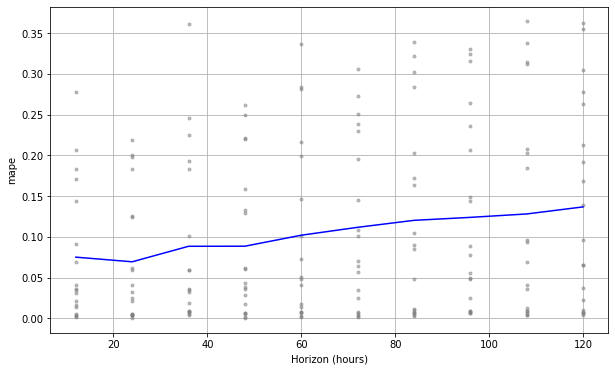

In [133]:
fig = plot_cross_validation_metric(conf_cv, metric='mape')

In [134]:
# Mean absolute percentage error function
def mape(y, y_pred):
    y, y_pred = np.array(y), np.array(y_pred)
    return np.mean(np.abs((y - y_pred) / y)) * 100

mape_confirmed = mape(conf_cv.y, conf_cv.yhat)
print('Confirmed Cases - Mean absolute percentage error: {:.4f}'.format(mape_confirmed))

Confirmed Cases - Mean absolute percentage error: 10.4370


In [135]:
# Performance metrics function
def performance_eval(y, y_pred):
    mse = sklm.mean_squared_error(y, y_pred)
    mse_log = sklm.mean_squared_log_error(y, y_pred)
    r2 = sklm.r2_score(y, y_pred)
    return mse, mse_log, r2

mse_conf, mse_log_conf, r2_conf = performance_eval(conf_cv.y, conf_cv.yhat)
print ('Confirmed Cases:- mse: {:.3f}, mse_log: {:.3f}, r2: {:.3f}'.format(mse_conf, mse_log_conf, r2_conf))

Confirmed Cases:- mse: 6827939273.092, mse_log: 0.027, r2: 0.996


### To find the saturation point of the outbreak for Confirmed cases

In [223]:
# Check growth factor for the past 30 days
dateminus30=(confirmed_fbp['ds'].tail(1).index-30).start
val_dateminus30=confirmed_fbp.iloc[dateminus30]['y']
val_current=confirmed_fbp.iloc[-1]['y']

#growth factor function
def growth_factor(initial, current):
    a = current - initial
    b = a / initial
    c = b * 100
    return round(b,4)

gf=growth_factor(val_dateminus30,val_current)

# Max cap value using growth factor
def max_cap_val(current, gf):
    a = current * gf
    b = a + current
    return b

cap=max_cap_val(val_current, gf)

In [224]:
# Experimenting the Logistic curve
confirmed_fbp_log=confirmed_fbp.copy()
confirmed_fbp_log['cap'] = int(cap)
confirmed_fbp_model_log = Prophet(growth='logistic', interval_width=0.99)
confirmed_fbp_model_log.fit(confirmed_fbp_log)
confirmed_fbp_model_log_future = confirmed_fbp_model_log.make_future_dataframe(periods=120,freq='D')
confirmed_fbp_model_log_future['cap']=int(cap)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [225]:
confirmed_fbp_model_log_pred = confirmed_fbp_model_log.predict(confirmed_fbp_model_log_future)

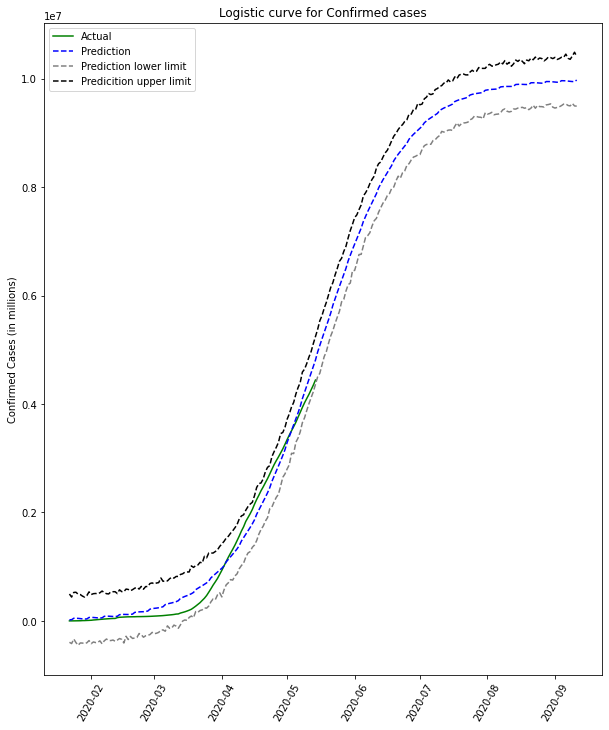

In [227]:
# matplotlib plot method
clog_forecast_yhat = []
clog_forecast_yhat_u = []
clog_forecast_yhat_l = []

for index, row in confirmed_fbp_model_log_pred.iterrows():

    clog_forecast_yhat.append(row['yhat'])
    clog_forecast_yhat_l.append(row['yhat_lower'])
    clog_forecast_yhat_u.append(row['yhat_upper'])

plt.ylabel('Confirmed Cases (in millions)')
plt.xticks(fontsize=10, rotation=60)
plt.plot(confirmed_fbp_log['ds'], confirmed_fbp_log['y'], label='Actual', color='green')
plt.plot(confirmed_fbp_model_log_pred['ds'], clog_forecast_yhat, label='Prediction', linestyle='dashed', color='blue')
plt.plot(confirmed_fbp_model_log_pred['ds'], clog_forecast_yhat_l, label='Prediction lower limit', linestyle='dashed', color='grey')
plt.plot(confirmed_fbp_model_log_pred['ds'], clog_forecast_yhat_u, label='Predicition upper limit', linestyle='dashed', color='black')
plt.title("Logistic curve for Confirmed cases")
plt.legend()
plt.show()

#### Death Case: Data Preprocessing

In [107]:
death_fbp.columns = ['ds','y']
death_fbp['ds'] = pd.to_datetime(death_fbp['ds'])

#### Death Case: model, fit and predict

In [109]:
# fitting / predicting the model
death_fbp_model = Prophet(growth ='linear', 
                              seasonality_mode='multiplicative',
                              changepoint_prior_scale=0.5,
                              weekly_seasonality=True,
                              daily_seasonality=True)
death_fbp_model.fit(death_fbp)
death_fbp_model_future = death_fbp_model.make_future_dataframe(periods=30,freq='D')
death_fbp_model_future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds
137,2020-06-07
138,2020-06-08
139,2020-06-09
140,2020-06-10
141,2020-06-11


In [110]:
death_fbp_model_pred = death_fbp_model.predict(death_fbp_model_future)
death_fbp_model_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2020-06-07,434260.376305,405667.251185,459614.683816
138,2020-06-08,437467.522875,406823.178238,463790.708809
139,2020-06-09,444321.628907,411691.448150,473040.429914
140,2020-06-10,454075.992174,419437.068746,484429.437295
141,2020-06-11,460349.636807,424026.491932,492528.553092


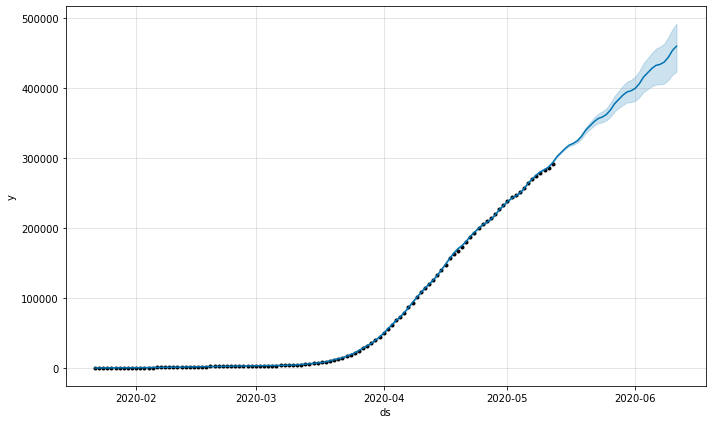

In [111]:
deaths_forecast_plot = death_fbp_model.plot(death_fbp_model_pred)

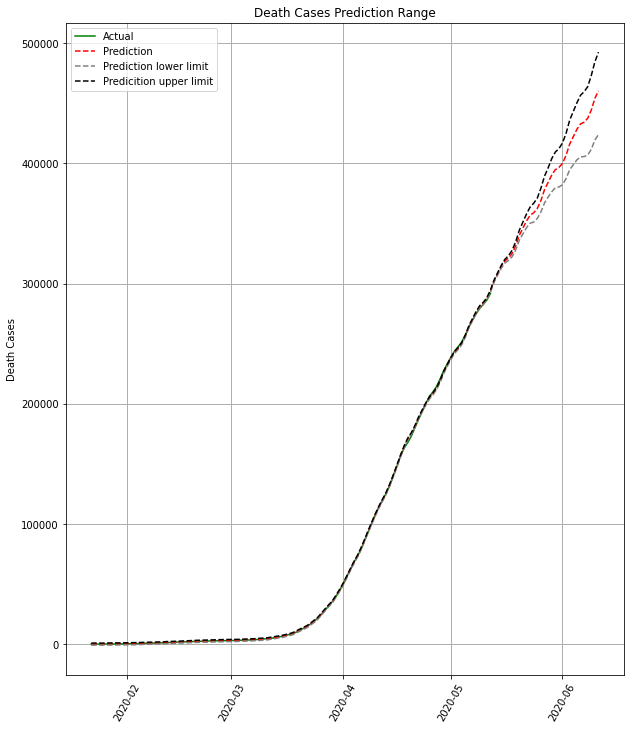

In [112]:
# matplotlib plot method
d_forecast_yhat = []
d_forecast_yhat_u = []
d_forecast_yhat_l = []

for index, row in death_fbp_model_pred.iterrows():

    d_forecast_yhat.append(row['yhat'])
    d_forecast_yhat_l.append(row['yhat_lower'])
    d_forecast_yhat_u.append(row['yhat_upper'])

plt.ylabel('Death Cases')
plt.xticks(fontsize=10, rotation=60)
plt.grid(linestyle='-', linewidth=1)
plt.plot(death_fbp['ds'], death_fbp['y'], label='Actual', color='green')
plt.plot(death_fbp_model_pred['ds'], d_forecast_yhat, label='Prediction', linestyle='dashed', color='red')
plt.plot(death_fbp_model_pred['ds'], d_forecast_yhat_l, label='Prediction lower limit', linestyle='dashed', color='grey')
plt.plot(death_fbp_model_pred['ds'], d_forecast_yhat_u, label='Predicition upper limit', linestyle='dashed', color='black')
plt.title("Death Cases Prediction Range")
plt.legend()
plt.show()

#### Death Case: Trends

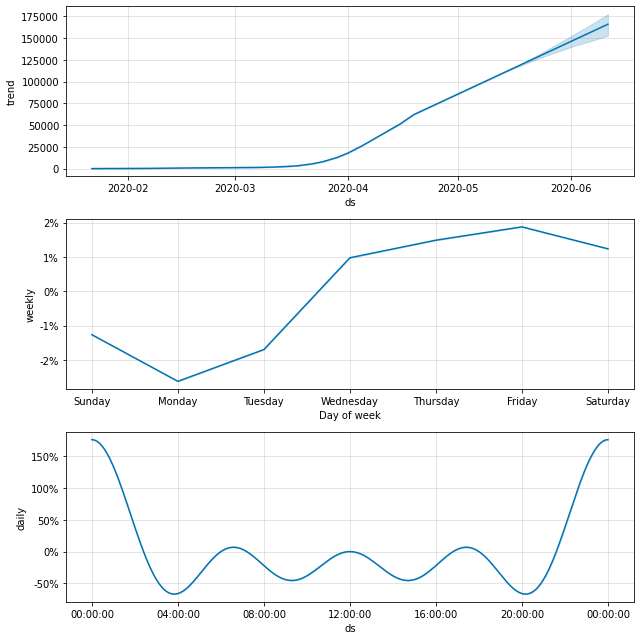

In [113]:
deaths_forecast_plot = death_fbp_model.plot_components(death_fbp_model_pred)

#### Death Case: Cross Validation, Performance Metrics

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-04-17 00:00:00 and 2020-04-17 00:00:00


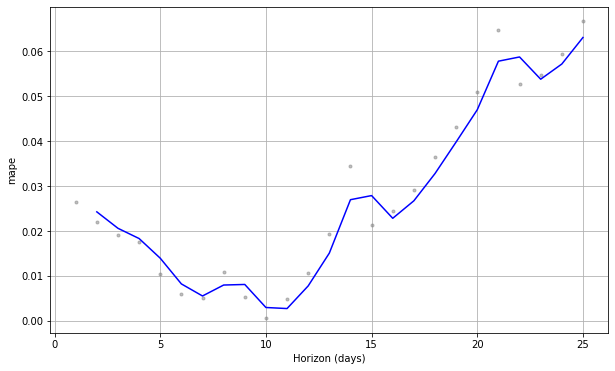

In [190]:
death_cv = cross_validation(death_fbp_model, initial='75 days', horizon = '25 days')
death_p = performance_metrics(death_cv)

fig = plot_cross_validation_metric(death_cv, metric='mape')

In [115]:
def mape(y, y_pred):
    y, y_pred = np.array(y), np.array(y_pred)
    return np.mean(np.abs((y - y_pred) / y)) * 100

mape_death = mape(death_cv.y, death_cv.yhat)
print('Death Cases - Mean absolute percentage error: {:.4f}'.format(mape_death))

Death Cases - Mean absolute percentage error: 2.7871


In [116]:
def performance_eval(y, y_pred):
    mse = sklm.mean_squared_error(y, y_pred)
    mse_log = sklm.mean_squared_log_error(y, y_pred)
    r2 = sklm.r2_score(y, y_pred)
    return mse, mse_log, r2

mse_death, mse_log_death, r2_death = performance_eval(death_cv.y, death_cv.yhat)
print ('Death Cases:- mse: {:.3f}, mse_log: {:.3f}, r2: {:.3f}'.format(mse_death, mse_log_death, r2_death))

Death Cases:- mse: 85155312.776, mse_log: 0.001, r2: 0.944


#### Recovered Case: Data Preprocessing

In [117]:
recovered_fbp.columns = ['ds','y']
recovered_fbp['ds'] = pd.to_datetime(recovered_fbp['ds'])

#### Recovered Case: model, fit and predict

In [118]:
recovered_fbp_model = Prophet(growth ='linear', 
                              seasonality_mode='multiplicative',
                              changepoint_prior_scale=0.5,
                              weekly_seasonality=True,
                              daily_seasonality=True)
recovered_fbp_model.fit(recovered_fbp)
recovered_fbp_model_future = recovered_fbp_model.make_future_dataframe(periods=30,freq='D')
recovered_fbp_model_future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds
137,2020-06-07
138,2020-06-08
139,2020-06-09
140,2020-06-10
141,2020-06-11


In [119]:
recovered_fbp_model_pred = recovered_fbp_model.predict(recovered_fbp_model_future)
recovered_fbp_model_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2020-06-07,2.482455e+06,2.317745e+06,2.658229e+06
138,2020-06-08,2.513885e+06,2.342609e+06,2.701736e+06
139,2020-06-09,2.544647e+06,2.359333e+06,2.734347e+06
140,2020-06-10,2.566775e+06,2.376652e+06,2.774003e+06
141,2020-06-11,2.626196e+06,2.419368e+06,2.853243e+06


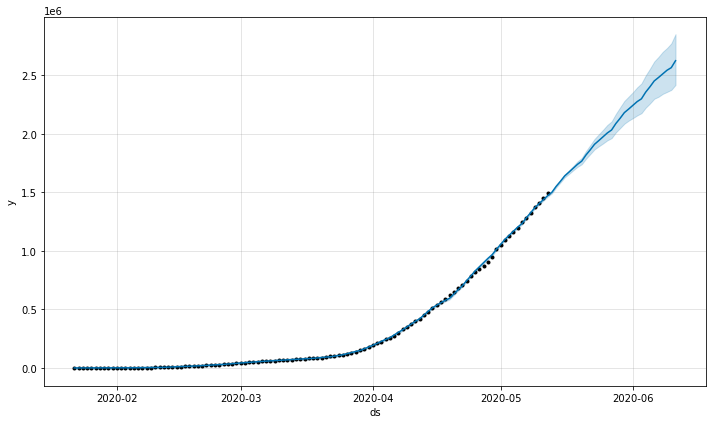

In [120]:
recovered_forecast_plot = recovered_fbp_model.plot(recovered_fbp_model_pred)

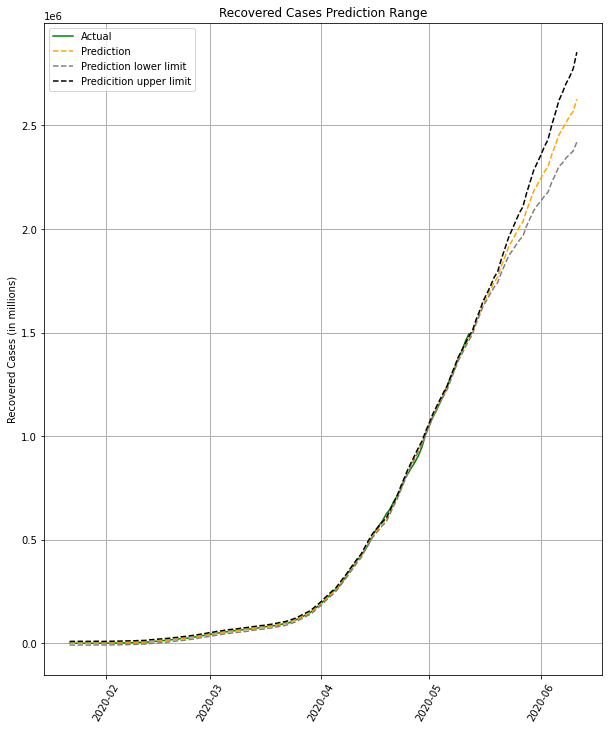

In [121]:
r_forecast_yhat = []
r_forecast_yhat_u = []
r_forecast_yhat_l = []

for index, row in recovered_fbp_model_pred.iterrows():

    r_forecast_yhat.append(row['yhat'])
    r_forecast_yhat_l.append(row['yhat_lower'])
    r_forecast_yhat_u.append(row['yhat_upper'])

#plt.xlabel('No. of Days')
plt.ylabel('Recovered Cases (in millions)')
plt.xticks(fontsize=10, rotation=60)
plt.grid(linestyle='-', linewidth=1)
plt.plot(recovered_fbp['ds'], recovered_fbp['y'], label='Actual', color='green')
plt.plot(recovered_fbp_model_pred['ds'], r_forecast_yhat, label='Prediction', linestyle='dashed', color='orange')
plt.plot(recovered_fbp_model_pred['ds'], r_forecast_yhat_l, label='Prediction lower limit', linestyle='dashed', color='grey')
plt.plot(recovered_fbp_model_pred['ds'], r_forecast_yhat_u, label='Predicition upper limit', linestyle='dashed', color='black')
plt.title("Recovered Cases Prediction Range")
plt.legend()
plt.show()

#### Recovered Case: Trends

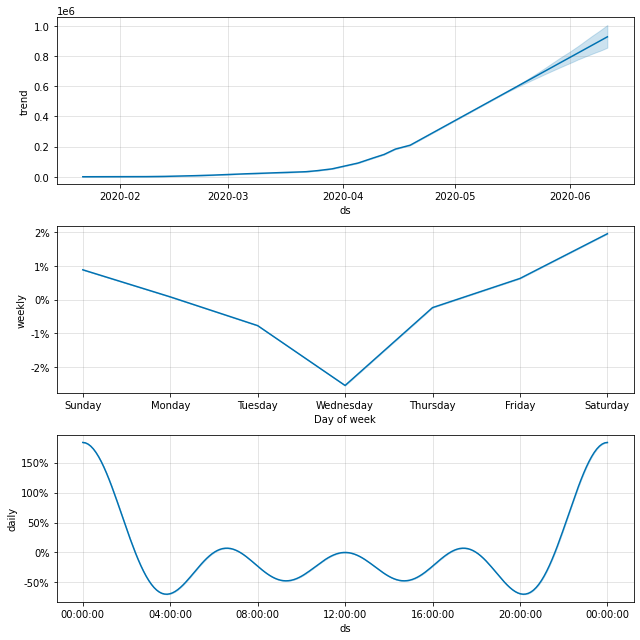

In [122]:
recovered_forecast_plot = recovered_fbp_model.plot_components(recovered_fbp_model_pred)

#### Recovered Case: Cross Validation and Performance Metrics

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-04-17 00:00:00 and 2020-04-17 00:00:00


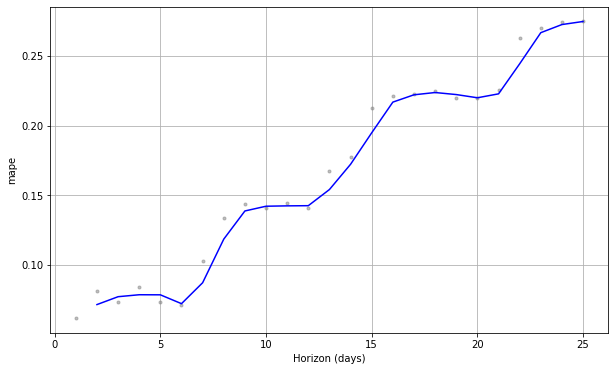

In [146]:
rec_cv = cross_validation(recovered_fbp_model, horizon = '25 days')#, initial='60 days', period='10 days', horizon = '30 days')
rec_p = performance_metrics(rec_cv)

fig = plot_cross_validation_metric(rec_cv, metric='mape')

In [124]:
def mape(y, y_pred):
    y, y_pred = np.array(y), np.array(y_pred)
    return np.mean(np.abs((y - y_pred) / y)) * 100

mape_confirmed = mape(rec_cv.y, rec_cv.yhat)
print('Confirmed Cases - Mean absolute percentage error: {:.4f}'.format(mape_confirmed))

Confirmed Cases - Mean absolute percentage error: 0.3472


In [126]:
def performance_eval(y, y_pred):
    mse = sklm.mean_squared_error(y, y_pred)
    mse_log = sklm.mean_squared_log_error(y, y_pred)
    r2 = sklm.r2_score(y, y_pred)
    return mse, mse_log, r2

mse_rec, mse_log_rec, r2_rec = performance_eval(rec_cv.y, rec_cv.yhat)
print ('Confirmed Cases:- mse: {:.3f}, mse_log: {:.3f}, r2: {:.3f}'.format(mse_rec, mse_log_rec, r2_rec))

Confirmed Cases:- mse: 223345927.365, mse_log: 0.000, r2: 0.999


### Actual vs Predicted Curves

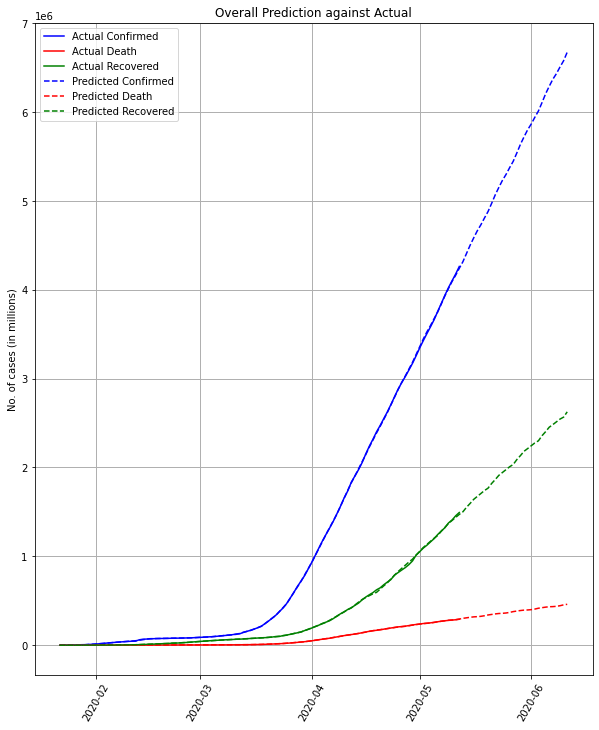

In [127]:
# Overall prediction graph
plt.ylabel('No. of cases (in millions)')
plt.xticks(fontsize=10, rotation=60)
plt.grid(linestyle='-', linewidth=1)
plt.plot(confirmed_fbp['ds'], confirmed_fbp['y'], label='Actual Confirmed', color='blue')
plt.plot(death_fbp['ds'], death_fbp['y'], label='Actual Death', color='red')
plt.plot(recovered_fbp['ds'], recovered_fbp['y'], label='Actual Recovered', color='green')
plt.plot(confirmed_fbp_model_pred['ds'], c_forecast_yhat, label='Predicted Confirmed', linestyle='dashed', color='blue')
plt.plot(death_fbp_model_pred['ds'], d_forecast_yhat, label='Predicted Death', linestyle='dashed', color='red')
plt.plot(recovered_fbp_model_pred['ds'], r_forecast_yhat, label='Predicted Recovered', linestyle='dashed', color='green')
plt.title("Overall Prediction against Actual")
plt.legend()
plt.show()

### Genrating Maps using Folium

In [128]:
# renaming the column names to lowercase for Map
confirmed_jhu.columns = map(str.lower, confirmed_jhu.columns)
deaths_jhu.columns = map(str.lower, deaths_jhu.columns)
recovered_jhu.columns = map(str.lower, recovered_jhu.columns)
countrycase_jhu.columns = map(str.lower, countrycase_jhu.columns)

In [129]:
# Removing rows with no location data
countrycase_jhu_m=countrycase_jhu
countrycase_jhu_m=countrycase_jhu_m[countrycase_jhu_m['lat'].notnull()]

In [222]:
covid19_map = folium.Map(location=[11,0], tiles="cartodbpositron", zoom_start=0, max_zoom = 6, min_zoom = 2)

for i in range(0,len(countrycase_jhu_m)):
    folium.Circle(
        location=[countrycase_jhu_m.iloc[i]['lat'], countrycase_jhu_m.iloc[i]['long_']],
        fill=True,
        radius=(int((np.log(countrycase_jhu_m.iloc[i,4]))))*60000,
        color='red',
        fill_color='orange',
        tooltip = "<div style='margin: 1; background-color: white; color: blue;'>"+
                    "<h4 style='text-align:center;font-weight: bold'>"+countrycase_jhu_m.iloc[i]['country'] + "</h4>"
                    "<hr style='margin:5px;color: blue;'>"+
                    "<ul style='color: blue;;list-style-type:box;align-item:left;padding-left:10px;padding-right:10px'>"+
                        "<li>Confirmed# "+str(countrycase_jhu_m.iloc[i,4])+"</li>"+
                        "<li>Deaths#   "+str(countrycase_jhu_m.iloc[i,5])+"</li>"+
                        "<li>Death Rate# "+ str(np.round(countrycase_jhu_m.iloc[i,5]/(countrycase_jhu_m.iloc[i,4])*100,2))+ "</li>"+
                    "</ul></div>"
        ).add_to(covid19_map)

covid19_map